Since the version 1.3, Spark has introduced the new data structure `DataFrame`. A data analyst now could easily scale out the exsiting codes based on the `DataFrame` from Python or R to a cluster hosting Hadoop and Spark.

There are quite a few practical scenarios that `DataFrame` fits well. For example, a lot of data files including the hardly read SAS files want to merge into a single data store. [Apache Parquet](https://parquet.apache.org/documentation/latest/) is a popular column store in a distributed environment, and especially friendly to structured or semi-strucutred data. It is an ideal candidate for a univeral data destination.

I copy three SAS files called `prdsale`, `prdsal2` and `prdsal3`, which are about a simulated sales record, from the SASHELP library to a Linux directory. And then I launch the SQL context from Spark 1.4. 

The three SAS files now have the size of 4.2MB. My overall strategy is to build a pipeline to realize my purpose such as `SAS --> Python --> Spark --> Parquet`.

In [1]:
import os
try:
    import sas7bdat
    import pandas
except ImportError:
    print('try to install the packags first')

print('Spark verion is {}'.format(sc.version))

if type(sqlContext) != pyspark.sql.context.HiveContext:
    print('reset the Spark SQL context')
    
os.chdir('/root/playground')
    
def print_bytes(filename):
    print('{} has {:,} bytes'.format(filename, os.path.getsize(filename)))
    
print_bytes('prdsale.sas7bdat')
print_bytes('prdsal2.sas7bdat')
print_bytes('prdsal3.sas7bdat')

!du -ch --exclude=test_parquet

Spark verion is 1.4.0
prdsale.sas7bdat has 148,480 bytes
prdsal2.sas7bdat has 2,790,400 bytes
prdsal3.sas7bdat has 1,401,856 bytes
4.2M	.
4.2M	total


####1. Test DataFrame in Python and Spark

First I transform a SAS `sas7bdat` file to a pandas DataFrame.  The great thing in Spark is that a Python/pandas DataFrame could be translated to Spark DataFrame by the `createDataFrame` method. Now I have two DataFrames: one is a pandas DataFrame and the other is a Spark DataFrame. 

In [4]:
with sas7bdat.SAS7BDAT('prdsale.sas7bdat') as f:
     pandas_df = f.to_data_frame()
print('-----Data in Pandas dataframe-----')
print(pandas_df.head())

print('-----Data in Spark dataframe-----')
spark_df = sqlContext.createDataFrame(pandas_df)
spark_df.show(5)

-----Data in Pandas dataframe-----
   ACTUAL COUNTRY   DIVISION  MONTH  PREDICT   PRODTYPE PRODUCT  QUARTER  \
0     925  CANADA  EDUCATION  12054      850  FURNITURE    SOFA        1   
1     999  CANADA  EDUCATION  12085      297  FURNITURE    SOFA        1   
2     608  CANADA  EDUCATION  12113      846  FURNITURE    SOFA        1   
3     642  CANADA  EDUCATION  12144      533  FURNITURE    SOFA        2   
4     656  CANADA  EDUCATION  12174      646  FURNITURE    SOFA        2   

  REGION  YEAR  
0   EAST  1993  
1   EAST  1993  
2   EAST  1993  
3   EAST  1993  
4   EAST  1993  
-----Data in Spark dataframe-----
+------+-------+---------+-------+-------+---------+-------+-------+------+------+
|ACTUAL|COUNTRY| DIVISION|  MONTH|PREDICT| PRODTYPE|PRODUCT|QUARTER|REGION|  YEAR|
+------+-------+---------+-------+-------+---------+-------+-------+------+------+
| 925.0| CANADA|EDUCATION|12054.0|  850.0|FURNITURE|   SOFA|    1.0|  EAST|1993.0|
| 999.0| CANADA|EDUCATION|12085.0|  297.

The two should be the identical length. Here both show 1,440 rows. 

In [5]:
print(len(pandas_df))
print(spark_df.count())

1440
1440


####2. Automate  the transformation

I write a pipeline function to automate the transformation. As the result, the all three SAS files are saved to the same directory as Parquet format.

In [6]:
def sas_to_parquet(filelist, destination):
    """Save SAS file to parquet
    Args:
        filelist (list): the list of sas file names
        destination (str): the path for parquet
    Returns:
        None
    """
    rows = 0
    for i, filename in enumerate(filelist):
        with sas7bdat.SAS7BDAT(filename) as f:
            pandas_df = f.to_data_frame()
            rows += len(pandas_df)
        spark_df = sqlContext.createDataFrame(pandas_df)
        spark_df.save("{0}/key={1}".format(destination, i), "parquet")
    print('{0} rows have been transformed'.format(rows))
    
sasfiles = [x for x in os.listdir('.') if x[-9:] == '.sas7bdat']
print(sasfiles)

sas_to_parquet(sasfiles, '/root/playground/test_parquet')


['prdsale.sas7bdat', 'prdsal2.sas7bdat', 'prdsal3.sas7bdat']
36000 rows has been transformed


Then I read from the newly created Parquet data store. The query shows that the data has been successfully saved.

In [11]:
df = sqlContext.load("/root/playground/test_parquet", "parquet")
print(df.count())
df.filter(df.key == 0).show(5)

36000
+------+-------+------+----+-------+-------+---------+-------+-------+-----+------+-----+---------+------+---+
|ACTUAL|COUNTRY|COUNTY|DATE|  MONTH|PREDICT| PRODTYPE|PRODUCT|QUARTER|STATE|  YEAR|MONYR| DIVISION|REGION|key|
+------+-------+------+----+-------+-------+---------+-------+-------+-----+------+-----+---------+------+---+
| 925.0| CANADA|  null|null|12054.0|  850.0|FURNITURE|   SOFA|    1.0| null|1993.0| null|EDUCATION|  EAST|  0|
| 999.0| CANADA|  null|null|12085.0|  297.0|FURNITURE|   SOFA|    1.0| null|1993.0| null|EDUCATION|  EAST|  0|
| 608.0| CANADA|  null|null|12113.0|  846.0|FURNITURE|   SOFA|    1.0| null|1993.0| null|EDUCATION|  EAST|  0|
| 642.0| CANADA|  null|null|12144.0|  533.0|FURNITURE|   SOFA|    2.0| null|1993.0| null|EDUCATION|  EAST|  0|
| 656.0| CANADA|  null|null|12174.0|  646.0|FURNITURE|   SOFA|    2.0| null|1993.0| null|EDUCATION|  EAST|  0|
+------+-------+------+----+-------+-------+---------+-------+-------+-----+------+-----+---------+------+

####3. Conclusion

There are multiple advantages to tranform data from various sources to Parquet.

1. It is an open format that could be read and written by major softwares. 
2. It could be well distributed to HDFS. 
3. It compresses data. 

For example, the original SAS files add up to 4.2 megabyte. Now as Parquet, it only weighs 292KB and achieves 14X compression ratio. 

In [9]:
os.chdir('/root/playground/test_parquet/')
!du -ahc 

4.0K	./key=2/._metadata.crc
4.0K	./key=2/._SUCCESS.crc
0	./key=2/_SUCCESS
4.0K	./key=2/_common_metadata
4.0K	./key=2/.part-r-00001.gz.parquet.crc
4.0K	./key=2/._common_metadata.crc
4.0K	./key=2/_metadata
60K	./key=2/part-r-00001.gz.parquet
88K	./key=2
4.0K	./key=0/._metadata.crc
4.0K	./key=0/._SUCCESS.crc
0	./key=0/_SUCCESS
4.0K	./key=0/_common_metadata
4.0K	./key=0/.part-r-00001.gz.parquet.crc
4.0K	./key=0/._common_metadata.crc
4.0K	./key=0/_metadata
12K	./key=0/part-r-00001.gz.parquet
40K	./key=0
4.0K	./key=1/._metadata.crc
4.0K	./key=1/._SUCCESS.crc
0	./key=1/_SUCCESS
4.0K	./key=1/_common_metadata
4.0K	./key=1/.part-r-00001.gz.parquet.crc
4.0K	./key=1/._common_metadata.crc
4.0K	./key=1/_metadata
132K	./key=1/part-r-00001.gz.parquet
160K	./key=1
292K	.
292K	total


A bar plot visualizes the signifcant size difference between the two formats. It shows an order of magnitudespace deduction. 

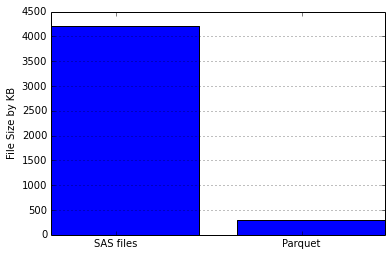

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
index = np.arange(2)
bar_width = 0.35
data = [4200, 292]
header = ['SAS files', 'Parquet']
plt.bar(index, data)
plt.grid(b=True, which='major', axis='y')
plt.ylabel('File Size by KB')
plt.xticks(index + bar_width, header)
plt.show()